#Субхангулов Султан. Лабораторная работа № 3. Латентное размещение Дирихле

In [1]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [2]:
!gdown --id 1JSlmhquvk5_0hP-H_IZ6IrL1OWOQRkVK

Downloading...
From: https://drive.google.com/uc?id=1JSlmhquvk5_0hP-H_IZ6IrL1OWOQRkVK
To: /content/wiki_movie_plots_deduped.csv
100% 81.2M/81.2M [00:00<00:00, 194MB/s]


In [3]:
rawdata = pd.read_csv("wiki_movie_plots_deduped.csv")

In [4]:
rawdata

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [5]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Julie Ann Turner, 17, wants to travel by car with friends Olive and Woody from her Pasadena, California home to Reno, Nevada, where her boyfriend Calvin Potter will be participating in a basketball game. Her mom Grace talks her opposed dad Gordon into letting her go.
Calvin makes a game-winning shot. Everyone celebrates afterward, and Julie Ann, in her excitement, suggests to Calvin that they elope, just as her Aunt Lola did at that age. Calvin agrees, but they decide to keep the wedding secret for a while when they get home.
As time goes by, Julie Ann asks friend Olive to accompany her to see an obstetrician. Rumor spreads that Olive is expecting a baby, so Julie Ann admits it's actually her. When the news is broken to her parents, it comes as news to Calvin, too. He moves in with the Turners, accepted by mother-in-law Grace but infuriating father-in-law Gordon, whose demand that the marriage be annulled is rejected with Julie being pregnant.
Calvin quarrels with his bride and relucta

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [6]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [8]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [9]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [10]:
print(data.sample(1).values[0])

in the fourth century ad sebastiane is a member of the emperor diocletian personal guard when he try to intervene to stop one of the emperor catamite from being strangled by one of his bodyguard sebastiane is exiled to a remote coastal garrison and reduced in rank to private although thought to be an early christian sebastiane is a worshipper of the roman sun god phoebus apollo and sublimate his desire for his male companion into worship of his deity and pacifism both incense severus the commanding officer of the garrison who becomes increasingly obsessed with sebastiane try to assault him and ultimately presides over his summary execution for refusing to take up arm in defence of the roman empire justin one of his comrade in arm is also in love with sebastiane albeit necessarily unrequited but he form a friendship with the stubborn celibate pacifist adrian and anthony two of sebastian fellow soldier are gay and in obvious love with one another


Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

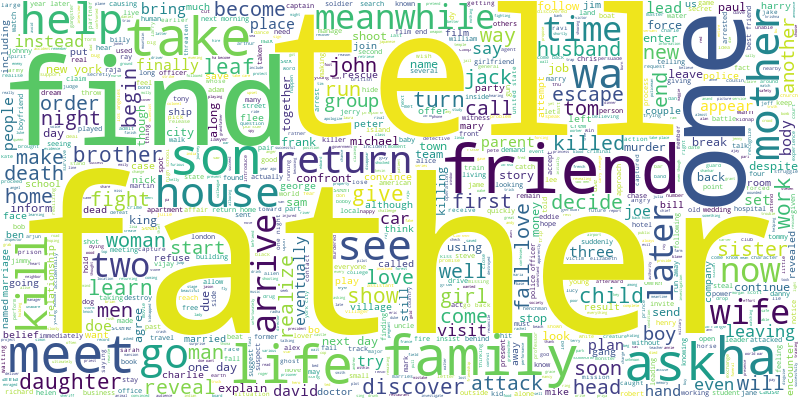

In [11]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [12]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

Посмотрим на распределение слов в нашем корпусе текстов

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


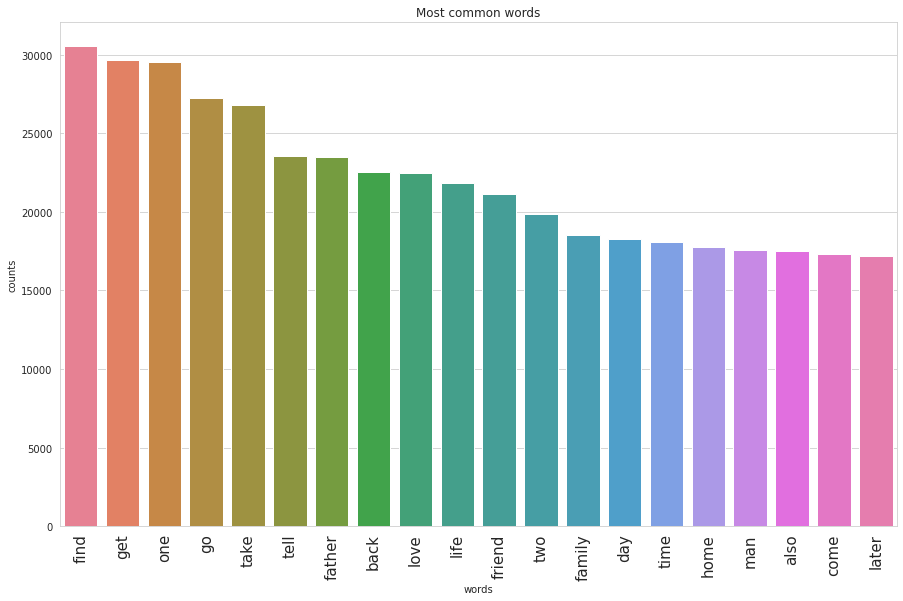

In [16]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [ ]:
def print_topics(count_vectorizer, model, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic, comp in enumerate(model.components_):
        print(f'\nTopic {topic+1}')
        idx = np.argsort(comp)[::-1][:n_top_words]
        for i in idx:
            print(words[i], end=' ')
        print()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

In [ ]:
lda = LatentDirichletAllocation(n_components=10)
X_new = lda.fit_transform(count_data)

In [ ]:
print_topics(count_vectorizer, lda, 5)


Topic 1
love get father family life 

Topic 2
love woman life wife tell 

Topic 3
tom jerry cat back get 

Topic 4
king one life film father 

Topic 5
find house jack body one 

Topic 6
ship war escape one attack 

Topic 7
harry tony kate daniel tell 

Topic 8
school get friend new go 

Topic 9
john car find go michael 

Topic 10
police money get joe find 


Что-то прорисовывается

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

In [ ]:
### YOUR CODE HERE
print('Сколько раз встречается каждая из тем')
np.unique(np.argmax(X_new, axis=1), return_counts=True)[1]

Сколько раз встречается каждая из тем


array([8270, 3892,  346, 2864, 2876, 4001,  330, 5628, 1687, 4992])

In [ ]:
def print_mutual_words(count_vectorizer, model, n_top_words):
    mutual_words = []
    words = count_vectorizer.get_feature_names_out()
    for topic, comp in enumerate(model.components_):
        idx = np.argsort(comp)[::-1][:n_top_words]
        mutual_words.append(idx)
    
    for topic_1 in range(len(mutual_words)):
        for topic_2 in range(topic_1 + 1, len(mutual_words)):
            intersection = set.intersection(set(mutual_words[topic_1]), mutual_words[topic_2])
            print(f'Topics {topic_1+1} and {topic_2+1} have intersection len {len(intersection)}')
            print(words[list(intersection)])

print_mutual_words(count_vectorizer, lda, 50)

Topics 1 and 2 have intersection len 35
['friend' 'daughter' 'make' 'girl' 'home' 'come' 'marriage' 'married'
 'house' 'find' 'marry' 'day' 'time' 'mother' 'also' 'take' 'meet' 'son'
 'two' 'child' 'one' 'father' 'go' 'man' 'life' 'later' 'want' 'doe' 'get'
 'wife' 'back' 'fall' 'tell' 'family' 'love']
Topics 1 and 3 have intersection len 17
['help' 'try' 'doe' 'back' 'end' 'go' 'fall' 'two' 'tell' 'take' 'make'
 'house' 'come' 'get' 'find' 'time' 'one']
Topics 1 and 4 have intersection len 28
['kill' 'friend' 'story' 'film' 'make' 'find' 'time' 'day' 'help' 'mother'
 'also' 'take' 'meet' 'son' 'two' 'child' 'one' 'brother' 'father' 'go'
 'man' 'life' 'later' 'back' 'village' 'tell' 'family' 'love']
Topics 1 and 5 have intersection len 22
['kill' 'house' 'home' 'come' 'find' 'time' 'day' 'mother' 'help' 'take'
 'two' 'child' 'one' 'father' 'go' 'police' 'man' 'later' 'get' 'try'
 'back' 'tell']
Topics 1 and 6 have intersection len 11
['kill' 'help' 'back' 'also' 'take' 'make' 'later' '

**Общих слов среди 50 самых популярных для каждых тем**

**Думаю, число 30 уже много**

**Например, посмотрев на топики 2 и 9, можно понять, что они очень близки**

**Но перечитав задание, понимаю, что не сосем это требовали**

In [ ]:
def most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    return count_dict
mc_words = most_common_words(count_data, count_vectorizer)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for topic in range(X_new.shape[1]):
    print(f'Topic {topic+1}')
    for w in mc_words[:5]:
        print(w[0], end='\t')
    print()
    for w in mc_words[:5]:
        occur = 0
        for row in data[np.argmax(X_new, axis=1) == topic]:
            occur += w[0] in row.split(' ')
        print(occur, end='\t')
    print()

Topic 1
find	get	one	go	take	
3294	4495	3698	3283	3576	
Topic 2
find	get	one	go	take	
1564	1223	1486	1396	1417	
Topic 3
find	get	one	go	take	
160	219	167	174	181	
Topic 4
find	get	one	go	take	
1002	670	1244	780	1053	
Topic 5
find	get	one	go	take	
1932	1227	1734	1574	1543	
Topic 6
find	get	one	go	take	
1800	1146	1951	1347	1787	
Topic 7
find	get	one	go	take	
202	172	203	192	212	
Topic 8
find	get	one	go	take	
2431	2556	2661	2463	2396	
Topic 9
find	get	one	go	take	
1004	957	985	928	1006	
Topic 10
find	get	one	go	take	
2104	2062	1955	1970	2005	


In [ ]:
# сравниваем сколько раз встречается каждая из тем
np.unique(np.argmax(X_new, axis=1), return_counts=True)[1]

array([8270, 3892,  346, 2864, 2876, 4001,  330, 5628, 1687, 4992])

**например get в 9 топике встречается довольно часто**

**вывод для задания: такие темы есть**

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

Так как все сопрягается, то $$q(t) = p(t|W,Φ,π)$$
$$p(t|W,Φ,π) = p(t,W|Φ,π) * const\\
q(t_d=k) = μ_{dk} = \prod_{d=d}\prod_{n=1}^{N_d}... * const = \\
= \frac{π_k \prod_{n=1}^{N_d} Φ_{k,w_{kn}}}{\sum_{k=1}^{T}...}\\ 
------------------------------------$$

$$E_{q(t)} log(p(t,W|Φ,π)) = E \sum_{d=1}^{D}\sum_{k=1}^{T}[t_d=k]*(log(\pi_k)+\sum_{n=1}^{N_d}log Φ_{k,w_{dn}}) = \sum_{d=1}^{D}\sum_{k=1}^{T}q(t_d=k)*(log(\pi_k)+\sum_{n=1}^{N_d}logΦ_{k,{w_{dn}}})\\ 
------------------------------------$$

$$L = ... + λ*(\sum_{k}^{T}π_k - 1)\\
L'_{π_τ} = \sum_{d=1}^{D}μ_{dτ}*\frac{1}{π_τ} + λ = 0\\ 
π_τ = \frac{\sum_{d=1}^{D}μ_{dτ}}{-λ}\\ 
\sum_{k}^{T}\frac{\sum_{d=1}^{D}μ_{dk}}{-λ} - 1 = 0\\ 
λ = - \sum_{k}^{T}\sum_{d=1}^{D}μ_{dk} = -\sum_{d=1}^{D}1 = -D\\ 
π_τ = \frac{\sum_{d=1}^{D}μ_{dτ}}{D}\\ 
-------------------------------------$$

$$L = \sum_{d=1}^{D}\sum_{k=1}^{T}μ_{dk}*(log(\pi_k)+\sum_{n=1}^{N_d}log \prod_{w=1}^{W}Φ_{k,w}^{[w_{dn}=w]}) + \sum_{k=1}^{T} λ_k (\sum_{w=1}^{W}Φ_{k,w} - 1)\\ 
L'_{Φ_{k',w'}} = \sum_{d=1}^{D}μ_{dk'}\sum_{n=1}^{N_d}[w_{dn}=w']\frac{1}{Φ_{k',w'}} + λ_{k'} = 0\\ 
Φ_{k',w'} = \frac{\sum_{d=1}^{D}μ_{dk'}\sum_{n=1}^{N_d}[w_{dn}=w']}{-λ_{k'}}\\ 
-λ_{k} = \sum_{w=1}^{W}\sum_{d=1}^{D}μ_{dk}\sum_{n=1}^{N_d}[w_{dn}=w] = \sum_{d=1}^{D}μ_{dk} N_d$$

Все, осталось подставить последнее в уравнение выше

$$-------------------------------------$$


$$LB = E_{q(t)} log(p(t,W|Φ,π)) - E_{q(t)} log(q(t)) = \sum_{d=1}^{D}\sum_{k=1}^{T}μ_{dk}*(log(\pi_k)+\sum_{n=1}^{N_d}logΦ_{k,{w_{dn}}}) - \sum_{d=1}^{D}\sum_{k=1}^{T}μ_{dk}log(μ_{dk})$$

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [76]:
def np_log(x):
    eps = 1e-8
    return np.log(x + eps)

In [79]:
from tqdm.notebook import tqdm

class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        ### YOUR CODE HERE ###
        self.mu = bow @ np_log(self.phi).T + np_log(self.pi)[None, :]
        self.mu = self.mu - np.max(self.mu, axis=1)[:, None]
        self.mu = np.exp(self.mu)
        self.mu = self.mu / np.sum(self.mu, axis=1)[:, None]
        # print('E', self._count_elbo(bow))
        
    def _m_step(self, bow):
        ### YOUR CODE HERE ###
        self.pi = np.mean(self.mu, axis=0)
        # print('M1', self._count_elbo(bow))

        self.phi = self.mu.T @ bow
        self.phi = self.phi / np.sum(self.phi, axis=1)[:, None]
        # print('M2', self._count_elbo(bow))
        
    def _count_elbo(self, bow):
        ### YOUR CODE HERE ###
        elbo = np.sum(self.mu * (bow @ np_log(self.phi).T + np_log(self.pi)[None, :] - np_log(self.mu)))
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [ ]:
### YOUR CODE HERE ###
lda_2 = SimpleLDA(n_topics=10)
lda_2.fit(count_data, verbose=True)

In [81]:
def print_topics_2(count_vectorizer, model, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic in range(model.phi.shape[0]):
        print(f'\nTopic {topic+1}')
        idx = np.argsort(model.phi[topic, :])[::-1][:n_top_words]
        for i in idx:
            print(words[i], end=' ')
        print()

In [82]:
print_topics_2(count_vectorizer, lda_2, 5)


Topic 1
find one life take love 

Topic 2
school life one get team 

Topic 3
find house go one tell 

Topic 4
find one back take escape 

Topic 5
tom jerry one take kill 

Topic 6
find get one take go 

Topic 7
get go tell find take 

Topic 8
get police love father one 

Topic 9
get find police one take 

Topic 10
love get father family life 



>>Topic 1
love get father family life 

>>Topic 2
love woman life wife tell 

>>Topic 3
tom jerry cat back get 

>>Topic 4
king one life film father 

>>Topic 5
find house jack body one 

>>Topic 6
ship war escape one attack 

>>Topic 7
harry tony kate daniel tell 

>>Topic 8
school get friend new go 

>>Topic 9
john car find go michael 

>>Topic 10
police money get joe find

По сравнению что было, конечно, хуже. Но интерпретировать можно некоторые. Остальные, например, 6 и 7... они отличаются?(нет) Много слов общего лексикона


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [98]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.1)
count_data = count_vectorizer.fit_transform(data.values)

In [ ]:
### YOUR CODE HERE ###
lda_2 = SimpleLDA(n_topics=10)
lda_2.fit(count_data, verbose=True)

In [100]:
print_topics_2(count_vectorizer, lda_2, 5)


Topic 1
singh raj khan india arjun 

Topic 2
jack frank john paul gang 

Topic 3
priya ajay shiva hospital ghost 

Topic 4
king army battle soldier war 

Topic 5
team david game joe charlie 

Topic 6
village raja rao ravi krishna 

Topic 7
ship war earth german alien 

Topic 8
bug harry john peter jeff 

Topic 9
tom jerry gang gun agent 

Topic 10
mary john york george play 


По-моему глупо удалять слова, которые встречаются более чем в 10% текстов. Остались лишь какие-то имена. Из-за того что у нас всего топиков 10, их общий смысл удаляется. Нужно либо повышать значение(10% текстов), либо увеличивать число топиков и искать что-то там.

В стандартной модели есть еще одна переменная(из какой темы пришло слово w_dn). Для слов общего лексикона модель может выделить отдельную тему и только для этой темы вероятность этого общего слова увеличивается. А потом слова для отдельного жанра могут перекрыть его. В упрощенной же у нас для каждой темы приходится увеличивать вероятность общих слов. Их как никак очень много, поэтому и сильно увеличивается.